# Lindblad equation

### Master eq. for a N-qubits system

Vamos a resolver la evolución temporal de la matriz de densidad de un sistema de dos qubits. Primero se va a resolver haciendo todos los cálculos, para luego compararlo con una funcion solver de qiskit y comprobar que se ha calculado correctamente (https://qiskit-community.github.io/qiskit-dynamics/tutorials/Lindblad_dynamics_simulation).

La master equation que vamos a estudiar es:

$$\frac{d}{dt} \rho(t) = -j [H, \rho] + \Gamma \sum_i\left( \sigma^{-}_i \rho \sigma^{+}_i - \frac{1}{2} \left\{ \sigma^{+}_i \sigma^{-}_i, \rho \right\} \right)$$




El Hamiltoniano del sistema que se ha tomado es el del modelo  TFIM (transverse field Ising model):

$$ H = - \sum_{i=1}^{N} \left[ J \sigma_z^i \sigma_z^{i+1} + g \sigma_x^i \right],$$

donde el primer término corresponde a la interacción entre qubits por el modelo de Ising y el segundo al efecto del campo transversal.


Primero definimos los operadores sobre un qubit en el espacio de Hilbert de N qubits. Vamos a definir la matrices de Pauli sobre el qubit i, por ejemplo para pauli(x):

$$X_i = I_1 \otimes I_2 \otimes \cdots \otimes \sigma^{x}_i \otimes I_{i+1} \otimes \cdots \otimes I_N$$

Se va a usar la función Pauli, que detecta la dimensión del espacio al sumarle un operador de zeros con esa misma dimensión y devuelve la matriz de Pauli correspondiente.


In [250]:
import numpy as np
from qiskit.quantum_info import Operator, Pauli

#tamaño del sistema
N = 2

#guardo los operadores para cada qubit
x_ops = []
y_ops = []
z_ops = []
qubits = range(N)

#defino un operador de ceros, ya que la función Pauli detecta la dim al sumarle este operador y 
#devuelve la matriz de pauli correspondiente en esa dim
zeros = Operator(np.zeros((2 ** N, 2 ** N)))

for i in qubits:
    X =  Pauli('X')(i) + zeros
    x_ops.append(X)

    Y = zeros + Pauli('Y')(i)
    y_ops.append(Y)

    Z = zeros + Pauli('Z')(i)
    z_ops.append(Z)



A continuación, definimos el estado inicial de la matriz de densidad. En este caso se ha construido el estado de Bell $$|\psi\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$$ mediante un circuito cuántico. Después, se dan valores a los parámetros y se calcula cada uno de los términos del Lindbladiano. 


Los operadores de salto son $$L_{\pm}=\sqrt{\Gamma}\sigma^{\pm}$$ con 

$$\sigma^{\pm} = \frac{1}{2} (\sigma^x \pm i \sigma^y)$$


In [251]:
from qiskit.quantum_info import DensityMatrix
from qiskit import QuantumCircuit
import numpy as np

# Circuito cuántico de 2 qubits en el estado de Bell |ψ⟩ = (|00⟩ + |11⟩) / √2
bell_circuit = QuantumCircuit(2)
bell_circuit.h(0)  
bell_circuit.cx(0, 1) 

# Definimos la matriz de densidad
rho_0 = DensityMatrix.from_instruction(bell_circuit)
rho_0_matrix = rho_0.data  # Convierte rho_0 a una matriz de numpy

#definimos algunos parámetros
g = 1.
J = 1.
Gamma = 4.
paso=0.01 #tamaño del paso en la simulación

#guardamos la evolución de la matriz densidad en cada paso
rho=[]
rho.append(rho_0_matrix)

#definimos el hamiltoniano
H = np.zeros((2**N, 2**N), dtype=complex)
for i in qubits:
    X = x_ops[i]
    H -= g* X

    #término de interacción entre qubits
    if (N > 1) & (i<N-1):
        j = (i + 1)
        op = zeros + Pauli('ZZ')(i, j)
        H -= J * op
        
H_matrix = H.data  # Convierte H a una matriz de numpy

#primer término de la ecuacion de lindblad
term1 = -1j * (np.dot(H_matrix, rho_0_matrix) - np.dot(rho_0_matrix, H_matrix))


#jump operators, segundo término de la ecuacion de lindblad
term2 = np.zeros((2**N, 2**N), dtype=complex)
for i in qubits:
     X = x_ops[i].data  # Convierte X a numpy
     Y = y_ops[i].data  # Convierte Y a numpy
    
     L_mas = np.sqrt(Gamma) * 0.5 * (X + 1j * Y)
     L_menos = L_mas.conj().T  # Conjugado transpuesto para el operador de Lindblad
    
     term2 += np.dot(L_mas, np.dot(rho_0_matrix, L_menos)) - 0.5*(np.dot(np.dot(L_menos, L_mas), rho_0_matrix) + np.dot(rho_0_matrix, np.dot(L_menos, L_mas))) 

#evlucionamos la matriz densidad con el tamaño de paso
rho_t=rho_0_matrix+ paso*(term1+term2) 
rho_t=rho_t/np.trace(rho_t)

rho.append(rho_t)


Ahora evolucionamos el sistema con $$\rho[t+1]=\rho[t]+h\times (evolución)$$
donde $h$ es el paso de la simulación.

In [252]:
#ahora evolucionamos el sistema de ecuaciones diferenciales

t_final = 8./Gamma
tau = .01 #tamaño del paso =paso
n_steps = int(np.ceil(t_final / tau)) + 1
t_eval = np.linspace(0., t_final, n_steps)

for k in range(1,n_steps):
    #primer termino de la ecuacion de lindblad
    term1 = -1j * (np.dot(H_matrix, rho_t) - np.dot(rho_t, H_matrix))
    
    #segundo termino de la ecuacion de lindblad
    term2 = np.zeros((2**N, 2**N), dtype=complex)
    for i in qubits:
         X = x_ops[i].data  # Convierte X a numpy
         Y = y_ops[i].data  # Convierte Y a numpy
        
         L_mas = np.sqrt(Gamma) * 0.5 * (X + 1j * Y)
         L_menos = L_mas.conj().T  # Conjugado transpuesto para el operador de Lindblad
        
         term2 += np.dot(L_mas, np.dot(rho_t, L_menos)) - 0.5*(np.dot(L_menos, np.dot(L_mas, rho_t)) + np.dot(rho_t, np.dot(L_menos, L_mas))) 
    rho_t+=paso*(term1+term2)
    rho_t=rho_t/np.trace(rho_t)
   
    rho.append(rho_t)



Calculamos single-qubit Pauli expectation values para $\sigma^x$ para comparar luego con el obtenido en la función solver.

In [253]:
#calculamos observables
#single-qubit pauli expectation values

x_data = np.zeros((N, n_times))
x_mean = np.zeros((n_times,))

for t_i in range(n_steps):
    for i in qubits:
        x_data[i, t_i] = np.trace(np.dot(x_ops[i].data,rho[t_i]))
    x_mean[t_i] = np.mean(x_data[:, t_i])


C:\Users\aileo\AppData\Local\Temp\ipykernel_15588\4170273865.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  x_data[i, t_i] = np.trace(np.dot(x_ops[i].data,rho[t_i]))


<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
C:\Users\aileo\AppData\Local\Temp\ipykernel_15588\2289663664.py:10: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(t_eval, x_mean, label = '$ N^{-1}\sum_i \\langle X_i \\rangle$')


Text(0.5, 1.0, 'Mean Bloch vector vs. $t$')

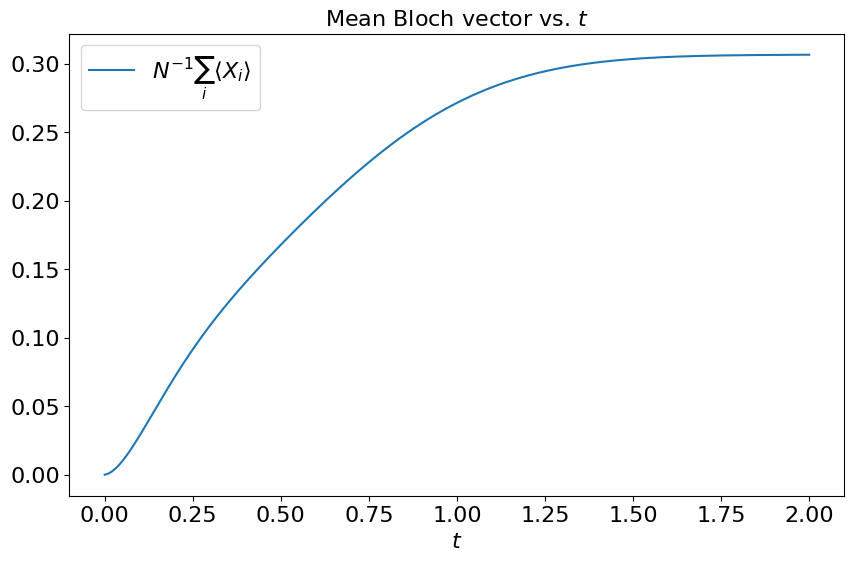

In [255]:
#plot del resultado
import matplotlib.pyplot as plt
%matplotlib inline

fontsize = 16

_, ax = plt.subplots(figsize = (10, 6))
plt.rcParams.update({'font.size': fontsize})
plt.plot(t_eval, x_mean, label = '$ N^{-1}\sum_i \\langle X_i \\rangle$')

plt.legend(fontsize = fontsize)
ax.set_xlabel('$t$', fontsize = fontsize)
ax.set_title('Mean Bloch vector vs. $t$', fontsize = fontsize)



A parte, vamos a representar la evolución de los términos diagonales de la matriz densidad:

C:\Users\aileo\AppData\Local\Temp\ipykernel_15588\1259349306.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  p00_data[i, t_i] = (rho[t_i])[0][0]
C:\Users\aileo\AppData\Local\Temp\ipykernel_15588\1259349306.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  p11_data[i, t_i] = (rho[t_i])[1][1]
C:\Users\aileo\AppData\Local\Temp\ipykernel_15588\1259349306.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  p22_data[i, t_i] = (rho[t_i])[2][2]
C:\Users\aileo\AppData\Local\Temp\ipykernel_15588\1259349306.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  p33_data[i, t_i] = (rho[t_i])[3][3]


Text(0.5, 1.0, '$\\rho_{ii}$ vs. $t$')

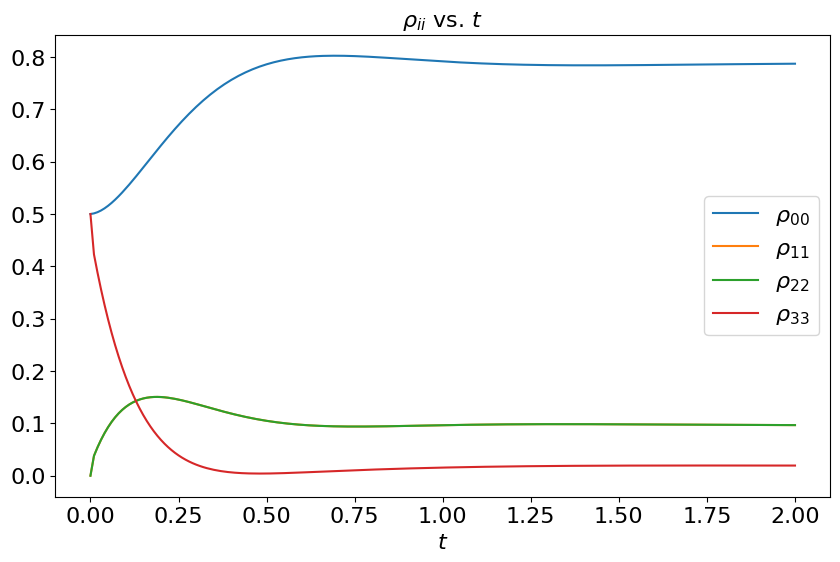

In [275]:
#diagonal matriz densidad p00, p11, p22, p33

import matplotlib.pyplot as plt
%matplotlib inline

p00_data = np.zeros((N, n_times))
p11_data = np.zeros((N, n_times))
p22_data = np.zeros((N, n_times))
p33_data = np.zeros((N, n_times))


for t_i in range(n_steps):
    for i in qubits:
        p00_data[i, t_i] = (rho[t_i])[0][0]
        p11_data[i, t_i] = (rho[t_i])[1][1]
        p22_data[i, t_i] = (rho[t_i])[2][2]
        p33_data[i, t_i] = (rho[t_i])[3][3]

fontsize = 16

_, ax = plt.subplots(figsize = (10, 6))
plt.rcParams.update({'font.size': fontsize})
plt.plot(t_eval, p00_data[0,], label = '$\\rho_{00}$')
plt.plot(t_eval, p11_data[0,], label = '$\\rho_{11}$')
plt.plot(t_eval, p22_data[0,], label = '$\\rho_{22}$')
plt.plot(t_eval, p33_data[0,], label = '$\\rho_{33}$')

plt.legend(fontsize = fontsize)
ax.set_xlabel('$t$', fontsize = fontsize)
ax.set_title(r'$\rho_{ii}$ vs. $t$', fontsize = fontsize)
    

## Comprobación con solver

In [228]:
import numpy as np
from qiskit.quantum_info import Operator, Pauli

N = 2

#guardo los operadores para cada qubit
x_ops = []
y_ops = []
z_ops = []
qubits = range(N)

#defino un operador de ceros, ya que la función Pauli detecta la dim al sumarle este operador y 
#devuelve la matriz de pauli correspondiente en esa dim
zeros = Operator(np.zeros((2 ** N, 2 ** N)))

for i in qubits:
    X =  Pauli('X')(i) + zeros
    x_ops.append(X)

    Y = zeros + Pauli('Y')(i)
    y_ops.append(Y)

    Z = zeros + Pauli('Z')(i)
    z_ops.append(Z)


In [229]:
from qiskit_dynamics import Solver, Signal

g = 1.
J = 1.
Gamma = 4.

#definimos el hamiltoniano
H = np.zeros((2**N, 2**N), dtype=complex)
for i in qubits:
    X = x_ops[i]
    H -= g* X
    
    if (N > 1) & (i<N-1):
        j = (i + 1)
        op = zeros + Pauli('ZZ')(i, j)
        H -= J * op
        
#jump operators, segundo termino de la ecuacion de lindblad
L_ops=[]
for i in qubits:
     X = x_ops[i]
     Y = y_ops[i] 
     L_ops.append(np.sqrt(Gamma) * 0.5 * (X + 1j * Y))

solver = Solver(static_hamiltonian=H, static_dissipators=L_ops)

In [230]:
from qiskit.quantum_info import DensityMatrix

t_final = 8. / Gamma
tau = .01

# Crear un circuito cuántico de 2 qubits en el estado de Bell |ψ⟩ = (|00⟩ + |11⟩) / √2
bell_circuit = QuantumCircuit(2)
bell_circuit.h(0)  
bell_circuit.cx(0, 1)  

# Convertir el estado resultante en una matriz de densidad
y0 = DensityMatrix.from_instruction(bell_circuit)

n_steps = int(np.ceil(t_final / tau)) + 1
t_eval = np.linspace(0., t_final, n_steps)

sol = solver.solve(t_span=[0., t_final], y0=y0, t_eval=t_eval)

In [231]:
n_times = len(sol.y)
x_data = np.zeros((N, n_times))
y_data = np.zeros((N, n_times))
z_data = np.zeros((N, n_times))
x_mean = np.zeros((n_times,))
y_mean = np.zeros((n_times,))
z_mean = np.zeros((n_times,))

for t_i, sol_t in enumerate(sol.y):
    for qubit, obs in enumerate(x_ops):
        x_data[qubit, t_i] = sol_t.expectation_value(obs).real
    x_mean[t_i] = np.mean(x_data[:, t_i])

    for qubit, obs in enumerate(y_ops):
        y_data[qubit, t_i] = sol_t.expectation_value(obs).real
    y_mean[t_i] = np.mean(y_data[:, t_i])

    for qubit, obs in enumerate(z_ops):
        z_data[qubit, t_i] = sol_t.expectation_value(obs).real
    z_mean[t_i] = np.mean(z_data[:, t_i])

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
C:\Users\aileo\AppData\Local\Temp\ipykernel_15588\1633244834.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(t_eval, x_mean, label = '$ N^{-1}\sum_i \\langle X_i \\rangle$')


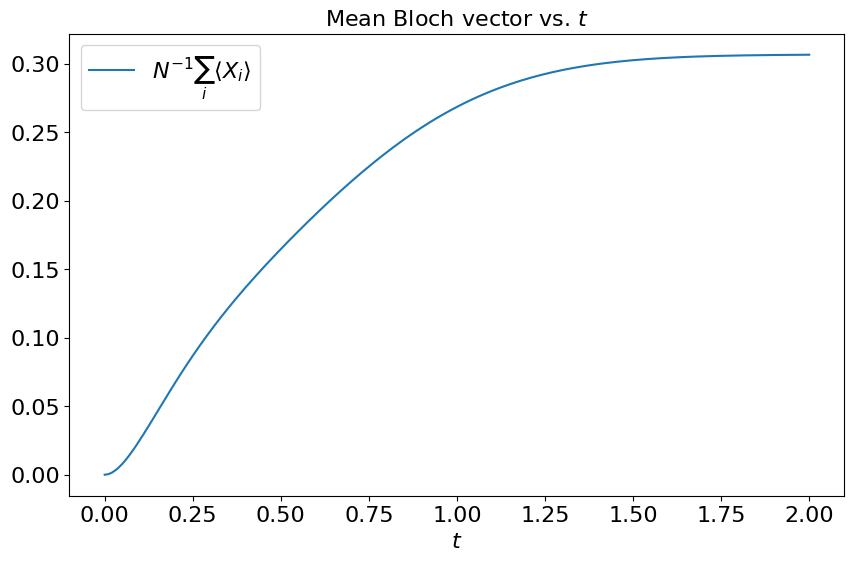

In [232]:
from qiskit.visualization import plot_bloch_vector
import matplotlib.pyplot as plt
%matplotlib inline

fontsize = 16

_, ax = plt.subplots(figsize = (10, 6))
plt.rcParams.update({'font.size': fontsize})
plt.plot(t_eval, x_mean, label = '$ N^{-1}\sum_i \\langle X_i \\rangle$')
#plt.plot(t_eval, y_mean, label = '$ N^{-1}\sum_i \\langle Y_i \\rangle$')
#plt.plot(t_eval, z_mean, label = '$ N^{-1}\sum_i \\langle Z_i \\rangle$')
plt.legend(fontsize = fontsize)
ax.set_xlabel('$t$', fontsize = fontsize)
ax.set_title('Mean Bloch vector vs. $t$', fontsize = fontsize)


if N > 1 and ((abs(x_mean[-1]) > 1e-5 and abs(x_data[0, -1] / x_mean[-1] - 1) > 1e-5 or
              (abs(z_mean[-1]) > 1e-5 and abs(z_data[1, -1] / z_mean[-1] - 1) > 1e-5))):
    print("The solution at the final time appears to break translation invariance. "
          "The precision of the simulation should be examined.")